<a href="https://colab.research.google.com/github/FranciscoValadares/why-baby-cry/blob/master/why_baby_cry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy files *.wav(into datasets/audios) to directory /content of the google colab
!cp -r 'drive/My Drive/Colab Notebooks/Exemplos/data/datasets/audios' /content/datasets/

# Time to preparing files for training - Simple training tutorial

The objective of this tutorial is to show you the basics of the library and how it can be used to simplify the audio processing pipeline.
[Ref](https://forums.fast.ai/t/fastai-v2-audio/53535/85)
This page is generated from the corresponding jupyter notebook, that can be found on [this folder](https://github.com/fastaudio/fastaudio/tree/master/docs)


To install the library, just run this cell:

In [ ]:
!pip install git+https://github.com/fastaudio/fastaudio.git
#!pip install git+https://github.com/fastai/fastai.git
#!pip install git+https://github.com/fastaudio/fastaudio.git
#!pip install git+https://github.com/FranciscoValadares/fastaudio.git

In [ ]:
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastai.vision.all import *
import pandas as pd

####---------- generating datasets

In [ ]:
!for i in {1..100}; do cp -rvfp /content/datasets/audio/hungry_00.wav /content/datasets/audio/"hungry_$i.wav" ;done

In [ ]:
!for i in {1..100}; do cp -rvfp /content/datasets/audio/sleep_00.wav /content/datasets/audio/"sleep_$i.wav" ;done

In [ ]:
!for i in {1..100}; do cp -rvfp /content/datasets/audio/burp_00.wav /content/datasets/audio/"burp_$i.wav" ;done

In [ ]:
!for i in {1..100}; do cp -rvfp /content/datasets/audio/disconfort_00.wav /content/datasets/audio/"disconfort_$i.wav" ;done

In [ ]:
!for i in {1..100}; do cp -rvfp /content/datasets/audio/lowergas_00.wav /content/datasets/audio/"lowergas_$i.wav" ;done

In [ ]:
import os

def renomear_arquivos():
    path_audio = "/content/datasets/audio/"
    for count, filename in enumerate(os.listdir(path_audio)):
        dst = ''
        src = ''
        if "hungry" in filename:
            src = path_audio+filename 
            dst = path_audio+"1_" + str(filename)
        elif "sleep" in filename:
            src = path_audio+filename         
            dst = path_audio+"2_" + str(filename)
        elif "disconfort" in filename:
            src = path_audio+filename         
            dst = path_audio+"3_" + str(filename)
        elif "lowergas" in filename:
            src = path_audio+filename         
            dst = path_audio+"4_" + str(filename)
        elif "burp" in filename:
            src = path_audio+filename         
            dst = path_audio+"5_" + str(filename)

        os.rename(src, dst )

In [ ]:
renomear_arquivos()

#---------Inicio tutorial 7-Audio

In [ ]:
path_audio = "/content/datasets/audio/"
path_audio_cached = "/content/datasets/audio_cached"

In [ ]:
def label_func(fname):
    _label = ''
    if fname.name[0] in "1":
      _label = "hungry"
    elif fname.name[0] in "2":
      _label = "sleep"
    elif fname.name[0] in  "3":
      _label = "disconfort"
    elif fname.name[0] in "4":
      _label = "lowergas"
    elif fname.name[0] in "5":
      _label = "burp"

    return _label


In [ ]:
#def get_y(x) : return x.name[0]

In [ ]:
#!rm -rf "/content/datasets/audio_cached" if executed more the one time (AudioBlock.from_folder)
audioBlock =  AudioBlock.from_folder(path_audio,sample_rate=2000)
crop_time  =  ResizeSignal(2000)
silence    =  RemoveSilence()

In [ ]:
sg_cfg = AudioConfig.BasicSpectrogram(n_fft=2000, hop_length=155) 
a2sg   = AudioToSpec.from_cfg(sg_cfg)

In [ ]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = [silence,Normalize(),crop_time,a2sg],
                 get_y=label_func)

In [ ]:
dbunch = aud_digit.dataloaders(path_audio_cached, bs=64)

In [ ]:
learn = cnn_learner(dbunch, 
            resnet34, 
            config=cnn_config(n_in=1), #<- Only audio specific modification here
            loss_fn=CrossEntropyLossFlat,
            metrics=[accuracy])

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0006918309954926372)

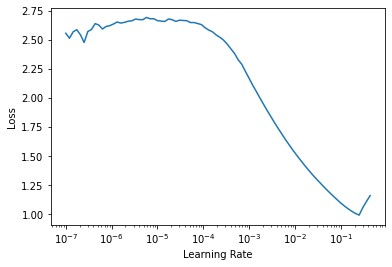

In [ ]:
learn.lr_find()
#better result learn.lr_find() for me: SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0006918309954926372)


In [ ]:
#learn.fit_one_cycle(, lr_max=0.025118863582611083)

In [ ]:
learn.fine_tune(10,base_lr=0.025118863582611083)

In [ ]:
learn.export()

### ===========================================================================================

###Test local model

In [ ]:
pkl_filename = '/content/export.pkl'

file = open(pkl_filename,'rb')
loaded_model = pickle.load(file)
#loaded_model = learner.load_learner("/content/export.pkl")
#loaded_model = learn

In [ ]:

path_item = PosixPath("/content/file_audio_baby_cry.wav")
Ypredict = loaded_model.predict(path_item)
Ypredict